In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from Vision.ImageHelpers import *
from Vision.SSD import *
from Datasets.RoadDamage import RoadDamageDataset
from Vision.RetinaNet import * 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True

In [5]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, x, bbox, clas=None, prs=None, thresh=0.3, show_bg=False):
    im = np.moveaxis(x, 0, 2)
    bb = [center_to_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im.clip(0,1), ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh) and (show_bg or c != 0)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += classes[c]
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.25, show_bg=False):
    return show_ground_truth(ax, ima, (bbox*imsize),
         clas, prs if prs is not None else None, thresh, show_bg=show_bg)

def test(sess, anchors, grid, data):
    with EvalModel(sess.model):
        rawx, rawy, *_ = next(iter(data))
        pred_classes, bb_outputs = sess.forward(rawx)
        prints = {key: val.numpy() for key, val in rawy.items()}
        y = {key: Variable(value) for key, value in rawy.items()}

        for i, x in enumerate(rawx[0:16]):
            im = denorm(rawx[i]).numpy()

            pred_classes_1, bb_outputs_1 = pred_classes[i], bb_outputs[i]
            label_bbs, label_classes = y['BB'][i], y['CAT'][i]

            fig, axes = plt.subplots(3, 2, figsize=(18, 18))


            # Ground Truth
            show_ground_truth(axes.flat[0], im, prints['BB'][i], prints['CAT'][i])


            # Anchorbox Assignments 
            gt_bbs, gt_classes, *_ = map_label_to_ground_truth(label_bbs, label_classes, anchors, grid, imsize)
            torch_gt(axes.flat[1], im, anchors.cpu().data.numpy(), gt_classes.cpu().data.numpy(), show_bg=False)


            # Predicted classes per anchorbox
            torch_gt(axes.flat[2], im, 
                     anchors.cpu().data.numpy(), 
                     pred_classes_1.max(1)[1].data, 
                     pred_classes_1.max(1)[0].sigmoid().data, 
                     show_bg=True)


            # Predicted classes per anchorbox. No background
            torch_gt(axes.flat[3], im, 
                     anchors.cpu().data.numpy(), 
                     pred_classes_1[:,1:].max(1)[1].data + 1, 
                     pred_classes_1[:,1:].max(1)[0].sigmoid().data, 
                     thresh=0.15,
                     show_bg=False)


            # Predicted class and bounding box
            a_ic = map_bb_outputs_to_pred_bbs(bb_outputs_1, anchors, grids)
            torch_gt(axes.flat[4], im, 
                     a_ic.cpu().data.numpy(), 
                     pred_classes_1[:,1:].max(1)[1].data + 1, 
                     pred_classes_1[:,1:].max(1)[0].sigmoid().data, 
                     thresh=0.15, 
                     show_bg=False)


            # Non Maximum Supression Outputs
            nms_classes, nms_conf, nms_bbs = make_output(pred_classes_1, bb_outputs_1, anchors, grids)
            nms_bbs_as_numpy = torch_corners_to_center(nms_bbs.cpu()).numpy()
            torch_gt(axes.flat[5], im, nms_bbs_as_numpy, nms_classes.cpu().numpy(), nms_conf.cpu().numpy())

In [9]:
imsize = 512
batch_size = 8
data, classes, train_tfms, val_tfms, denorm = RoadDamageDataset('../storage/road_damage_data', imsize, batch_size)
num_classes = len(classes) - 1
classes

{'train': array([5789, 3496, 2210, ..., 3101, 6133, 4233]), 'valid': array([3663, 4760, 6677, ..., 5563,  110,  708])}


['bg', 'D00', 'D01', 'D10', 'D11', 'D20', 'D40', 'D43', 'D44']

In [10]:
def var_from_np(arr, requires_grad=True):
    return Variable(torch.from_numpy(arr), requires_grad=requires_grad)

In [11]:
anc_grids = [32,16,8,4]

grid_sizes = [64,128,256,512]

anc_zooms = [2**0]

anc_ratios = [(1.,1.), (1.,0.35), (0.35,1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

3

In [12]:
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [13]:
anc_sizes  =   np.concatenate([np.array([[o*size/imsize,p*size/imsize] for i in range(ag*ag) for o,p in anchor_scales])
               for size, ag in zip(grid_sizes, anc_grids)])
np_grid_sizes = np.concatenate([np.array([ [size/imsize]       for i in range(ag*ag) for o,p in anchor_scales])
               for size, ag in zip(grid_sizes, anc_grids)])
np_anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1)

In [14]:
grids = Variable(torch.from_numpy(np.concatenate([anc_ctrs, np_grid_sizes, np_grid_sizes], axis=1))).float()
len(grids)

4080

In [15]:
anchors = var_from_np(np_anchors, requires_grad=False).float()
len(anchors)

4080

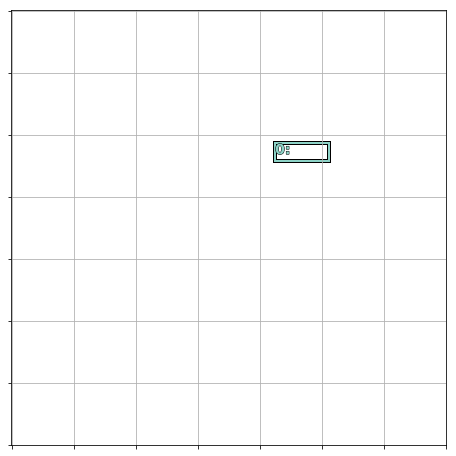

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
show_ground_truth(ax, np.ones((3, 224, 224)), anchors.data.cpu().numpy()[32*32] * 224)

In [ ]:
# model_ft = models.resnet50(pretrained=True)
# model_ft

In [ ]:
model = RetinaNet(classes=num_classes, anchors=k)
# model

In [ ]:
rawx, rawy, *_ = next(iter(data['valid'])) 
y = {key: Variable(value) for key, value in rawy.items()}

In [ ]:
criterion = SSDLoss(anchors, grids, num_classes, imsize)
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, 1e-3)

In [ ]:
sess.load("best-42-0.6069469835466179")

In [ ]:
batch = sess.forward(rawx)

In [ ]:
# batch

In [ ]:
criterion(batch, y, log=True)

In [ ]:
test(sess, anchors, grids, data['valid'])

In [ ]:
lr_find(sess, data['train'], start_lr=1e-7)

In [ ]:
sess.set_lr(1e-5)

In [ ]:
lr_scheduler = Cyclical(len(data['train']) * 63, cut_div=4, div=10, momentums=(.95,.8))
accuracy = JaccardAccuracy(anchors, grids, imsize, num_classes+1)
validator = Validator(data['valid'], accuracy, save_best=True)
schedule = TrainingSchedule(data['train'], [lr_scheduler, validator])

In [ ]:
lr_scheduler.plot(len(data['train']) * 63)

In [ ]:
validator.run(sess)

In [ ]:
sess.train(schedule, 63)

In [ ]:
sess.save("Resnet18DistanceMatching2")

In [ ]:
sess.load("Resnet18DistanceMatching2")

In [ ]:
test(sess, anchors, grids, data['valid'])

In [ ]:
criterion = SSDLoss(anchors, grids, num_classes, imsize)

In [ ]:
rawx, rawy, *_ = next(iter(data['valid']))
y =  {key: Variable(value) for key, value in rawy.items()}

In [ ]:
batch = sess.forward(rawx)

In [ ]:
criterion(batch, y, log=True)

In [ ]:
sess.train(schedule, 14)

In [ ]:
sess.save("Resnet34Multi2")

In [ ]:
sess.load("best-2-0.7926736199440345")

In [ ]:
test(sess, anchors, grids, data['valid'])

## Inference Test Data

In [ ]:
def inference_test_data():
    inferences = []

    prints = 0

    with EvalModel(sess.model):
        for x,y,meta in data['test']:
            pred_classes, bb_outputs = sess.forward(x)
            for idx, file in enumerate(meta['file']):
                nms_classes, nms_conf, nms_bbs = make_output(pred_classes[idx], bb_outputs[idx], anchors, grids)

                if prints < 16 and random.random() <= .01:
                    fig, ax = plt.subplots(figsize=(12,12))
                    ax.set_title(file.split("\\")[-1])
                    im = denorm(x[idx]).numpy()
                    nms_bbs_as_numpy = torch_corners_to_center(nms_bbs.cpu()).numpy()
                    torch_gt(ax, im, nms_bbs_as_numpy, nms_classes.cpu().numpy(), nms_conf.cpu().numpy())
                    prints += 1

                nms_classes, nms_conf, nms_bbs = nms_classes.cpu().numpy(), nms_conf.cpu().numpy(), nms_bbs.cpu().numpy()   

                preds = []

                for idx, cls, bb in zip(range(5), nms_classes, nms_bbs):
                    corners = (bb * 600).clip(0,600).astype(int)
                    if(not (corners[0] < corners[2] and corners[1] < corners[3])): continue
                    assert(corners[0] < corners[2] and corners[1] < corners[3])
                    preds.append(f'{cls} {" ".join(corners.astype(str))}')

                inferences.append({'filename': file.split("/")[-1], 'prediction': " ".join(preds)})

    df = pd.DataFrame(inferences, columns=['filename', 'prediction'])
    df.to_csv(f'Submissions/submission.{time.strftime("%Y%m%d-%H%M%S")}.csv', header=False, index=False)

In [ ]:
inference_test_data()